##### Library Imports

In [29]:
import warnings
warnings.filterwarnings("ignore")

import random
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.preprocessing import (OrdinalEncoder, OneHotEncoder, LabelEncoder, 
                                   StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler,
                                   PowerTransformer)
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc, f1_score
from sklearn.utils import resample
from lightgbm import Booster

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier, early_stopping as lgbm_early_stopping
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

%matplotlib inline

# Predicting Churn for IBM Subscription Service

**Goals:**
1. Use subscription service data to determine key factors driving churn for *Telco*--a Telecommunications business.
2. Train a machine learning model to be able to predict customer churn for more targeted churn-reduction strategies.

**In this notebook:**
- Prepare training and test datasets
- Encode categorical features
- Scale numerical features
- Create model fit function with K-Fold on ROC-AUC scoring
    - CatBoost Model
    - XGBoost Model
    - LGBM Model
    - Stacking Ensemble Model
- Plot feature importance

### Train/Test Split

In [3]:
# Get cleaned dataset
df = pd.read_csv("../data/telco_customer_churn_clean.csv")

# Fix randomness in all utility packages with seed
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)

TRAIN_TEST_RATIO = 0.8

# Split dataset into Training and Testing sets using train_test_split from Scikit Learn
def split_dataset(df, ratio=TRAIN_TEST_RATIO, seed=SEED):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Churn']), df['Churn'], train_size=ratio, random_state=seed, stratify=df['Churn'], shuffle=True)
    N_train, N_test = len(y_train), len(y_test)

    train_vc, test_vc = y_train.value_counts() / N_train * 100, y_test.value_counts() / N_test *100
    print(f"Training set size: {N_train}\t\tTesting set size: {N_test}\n")
    print(f"Churn Distribution:\t\tYes\tNo\nTraining\t\t\t{train_vc.iloc[0]:.2f}%\t{train_vc.iloc[1]:.2f}%\nTesting\t\t\t\t{test_vc.iloc[0]:.2f}%\t{test_vc.iloc[1]:.2f}%")

    # Get feature names
    features = X_train.columns

    return (X_train, y_train), (X_test, y_test), features

(X_pretrain, y_pretrain), (X_test, y_test), features = split_dataset(df)

# before encoding, save dataframes for inference
pd.concat([X_pretrain, y_pretrain], axis=1).to_pickle("../data/pretrain_decoded.pkl")
pd.concat([X_test, y_test], axis=1).to_pickle("../data/test_decoded.pkl")

# encode categorical features
cat_cols = list(set(features) - set(X_pretrain._get_numeric_data().columns))
ordinal_encoder = OrdinalEncoder()
X_pretrain[cat_cols] = ordinal_encoder.fit_transform(X_pretrain[cat_cols])
X_test[cat_cols] = ordinal_encoder.transform(X_test[cat_cols])

# encode target feature
label_binarizer = LabelEncoder()
y_pretrain = label_binarizer.fit_transform(y_pretrain)
y_test = label_binarizer.transform(y_test)

Training set size: 5634		Testing set size: 1409

Churn Distribution:		Yes	No
Training			73.46%	26.54%
Testing				73.46%	26.54%


### Individual Model Training

Before we create one ensemble model to rule them all, we'll need to optimize each of the individual models on this dataset. The model techniques we'll be examining are: XGBoost, CatBoost, and LightGBM. The steps we'll need to take in this section are as follows:

1. Define helper functions for model training
2. Apply one-off training with StratifiedKFolds
3. Execute comprehensive hyperparameter optimization with Optuna


##### Helper Functions + BaseModel Class

In [24]:
class BaseModel:
    def __init__(self, model, model_name: str, seed: int):
        self.model = model
        self.model_name = model_name
        self.seed = seed
    
    def fit(self, X_train, y_train, X_test, y_test, n_splits=10, options=None):
        """
        Fit the model using Stratified K-Fold cross-validation and compute AUC scores.
        """
        if options is None:
            options = {}

        auc_scores = []
        # Initialize arrays for storing out-of-fold predictions and test predictions
        oof_predictions = np.zeros((X_train.shape[0], 1))
        test_predictions = np.zeros((X_test.shape[0], n_splits))

        # Loop over train/validation folds
        folds = StratifiedKFold(n_splits=n_splits, random_state=self.seed, shuffle=True)
        for fold_index, (train_indices, val_indices) in enumerate(folds.split(X_train, y_train), start=1):
            # Train the model on this fold
            X_fold_train, y_fold_train = X_train.iloc[train_indices], y_train[train_indices]
            X_fold_val, y_fold_val = X_train.iloc[val_indices], y_train[val_indices]

            print(f"Fold {fold_index} - Training Start")
            auc = self.train(X_fold_train, y_fold_train, X_fold_val, y_fold_val, options)
            auc_scores.append(auc)
            print(f"Fold {fold_index} - Training Done | Fold AUC: {auc:.3f}")

            # Store out-of-fold predictions
            oof_predictions[val_indices, :] = self.model.predict_proba(X_fold_val)[:, 1].reshape(-1, 1)
            # Store test set predictions for averaging later
            test_predictions[:, fold_index - 1] = self.model.predict_proba(X_test)[:, 1]

        # Average test predictions across all folds
        test_predictions_mean = np.mean(test_predictions, axis=1).reshape(-1, 1)
        test_auc_score = roc_auc_score(y_test, test_predictions_mean)

        # Print overall AUC scores
        print(f"{self.model_name} Training Set".ljust(32), 
              f"AUC Score\tmean={np.mean(auc_scores):.3f}\tstd={np.std(auc_scores):.3f}")
        print(f"{self.model_name} Testing Set".ljust(32), 
              f"AUC Score={test_auc_score:.3f}")

        return oof_predictions, test_predictions_mean

    def train(self, X_train, y_train, X_val, y_val, options):
        self.model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **options)
        return roc_auc_score(y_val, self.predict_proba(X_val)[:,1])
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def plot(self, importances, features):
        imp_df = pd.DataFrame({'feature': np.array(features), 'importance': np.array(importances)})
        imp_df.sort_values(by=['importance'], ascending=False, inplace=True)

        plt.figure(figsize=(10,8), dpi=100)
        sns.barplot(x=imp_df['importance'], y=imp_df['feature'])
        plt.title(f"{self.model_name} Feature Importances")
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()
        plt.savefig(f"../images/{self.model_name}_importances.png")

    def save(self):
        print('Saved model to file')

# XGBoost Model implementation
class XGBModel(BaseModel):
    def __init__(self, params, seed: int):
        super().__init__(model=XGBClassifier(**params), model_name="xgboost", seed=seed)

    def fit(self, X, y, X_test, y_test):
        return super().fit(X, y, X_test, y_test, options={"verbose": False})

    def plot(self):
        return super().plot(self.model.feature_importances_, features)

    def save(self):
        self.model.save_model('../models/xgboost.json')

# CatBoost Model implementation
class CBModel(BaseModel):
    def __init__(self, params, seed: int):
        super().__init__(model=CatBoostClassifier(**params), model_name="catboost", seed=seed)

    def fit(self, X, y, X_test, y_test):
        return super().fit(X, y, X_test, y_test, options={"verbose": False})

    def plot(self):
        return super().plot(self.model.get_feature_importance(), features)

    def save(self):
        self.model.save_model('../models/catboost')

# LightGBM Model implementation
class LGBMModel(BaseModel):
    def __init__(self, params, seed: int):
        super().__init__(model=LGBMClassifier(**params), model_name="lightgbm", seed=seed)

    def fit(self, X, y, X_test, y_test):
        return super().fit(X, y, X_test, y_test, options={'eval_metric': 'auc', 'callbacks': [lgbm_early_stopping(200, verbose=False)]})

    def plot(self):
        return super().plot(self.model.feature_importances_, features)

    def save(self):
        self.model.booster_.save_model('../models/lightgbm.txt')

##### One-off Training

Fold 1 - Training Start
Fold 1 - Training Done | Fold AUC: 0.822
Fold 2 - Training Start
Fold 2 - Training Done | Fold AUC: 0.843
Fold 3 - Training Start
Fold 3 - Training Done | Fold AUC: 0.847
Fold 4 - Training Start
Fold 4 - Training Done | Fold AUC: 0.834
Fold 5 - Training Start
Fold 5 - Training Done | Fold AUC: 0.828
Fold 6 - Training Start
Fold 6 - Training Done | Fold AUC: 0.839
Fold 7 - Training Start
Fold 7 - Training Done | Fold AUC: 0.838
Fold 8 - Training Start
Fold 8 - Training Done | Fold AUC: 0.849
Fold 9 - Training Start
Fold 9 - Training Done | Fold AUC: 0.835
Fold 10 - Training Start
Fold 10 - Training Done | Fold AUC: 0.822
xgboost Training Set             AUC Score	mean=0.836	std=0.009
xgboost Testing Set              AUC Score=0.830


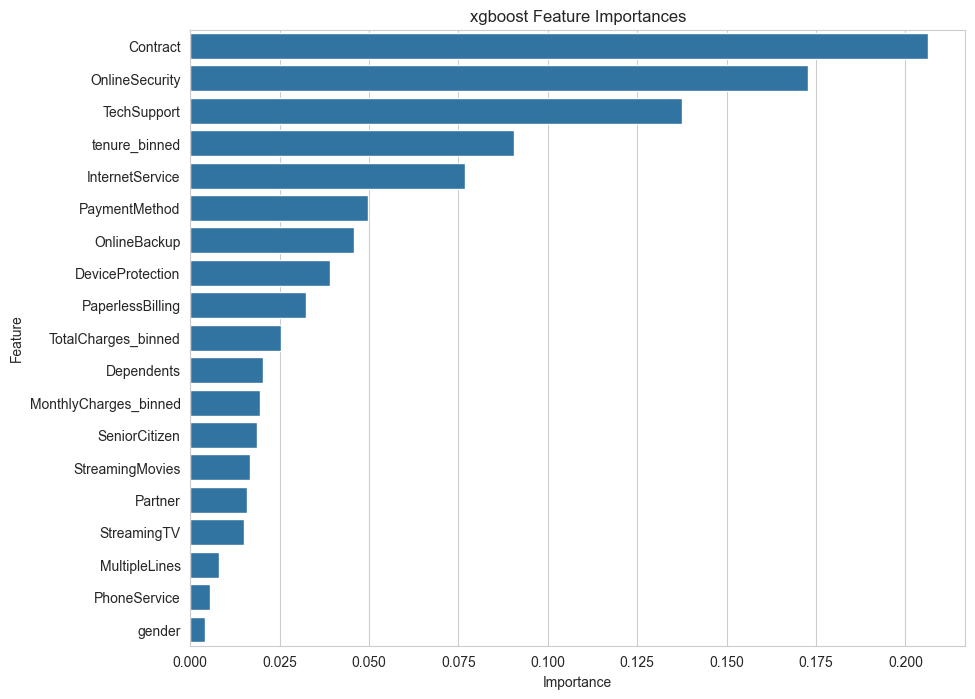

<Figure size 640x480 with 0 Axes>

In [81]:
xgboost = XGBModel({
    'random_state': SEED,
    'colsample_bytree': 0.25,
    'max_depth': 3,
    'learning_rate': 1.8e-3,
    'early_stopping_rounds': 200,
    'eval_metric': 'auc',
    'gamma': 0,
    'n_estimators': 10000,
    'reg_lambda': 0.1,
    'subsample': 0.70,
    'enable_categorical': True
}, SEED)
xgboost.fit(X_pretrain, y_pretrain, X_test, y_test)
xgboost.plot()
xgboost.save()

Fold 1 - Training Start
Fold 1 - Training Done | Fold AUC: 0.829
Fold 2 - Training Start
Fold 2 - Training Done | Fold AUC: 0.848
Fold 3 - Training Start
Fold 3 - Training Done | Fold AUC: 0.851
Fold 4 - Training Start
Fold 4 - Training Done | Fold AUC: 0.834
Fold 5 - Training Start
Fold 5 - Training Done | Fold AUC: 0.840
Fold 6 - Training Start
Fold 6 - Training Done | Fold AUC: 0.846
Fold 7 - Training Start
Fold 7 - Training Done | Fold AUC: 0.838
Fold 8 - Training Start
Fold 8 - Training Done | Fold AUC: 0.849
Fold 9 - Training Start
Fold 9 - Training Done | Fold AUC: 0.838
Fold 10 - Training Start
Fold 10 - Training Done | Fold AUC: 0.826
catboost Training Set            AUC Score	mean=0.840	std=0.008
catboost Testing Set             AUC Score=0.832


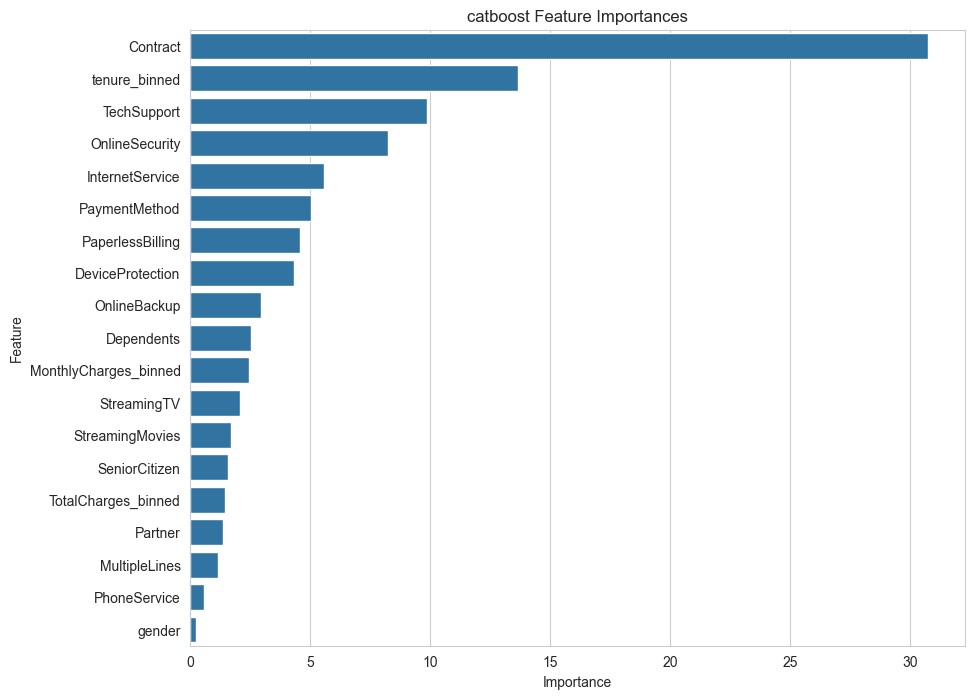

<Figure size 640x480 with 0 Axes>

In [82]:
# CatBoost model training
catboost = CBModel({
    'random_state': SEED,
    'colsample_bylevel': 1.3e-2,
    'depth': 6,
    'learning_rate': 5.5e-2,
    'eval_metric': "AUC",
    'loss_function': 'logloss',
    'objective': 'Logloss',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bayesian', 
    'iterations': 6888,
    'random_strength': 18, 
    'l2_leaf_reg': 50,
}, SEED)
catboost.fit(X_pretrain, y_pretrain, X_test, y_test)
catboost.plot()
catboost.save()

Fold 1 - Training Start
Fold 1 - Training Done | Fold AUC: 0.825
Fold 2 - Training Start
Fold 2 - Training Done | Fold AUC: 0.851
Fold 3 - Training Start
Fold 3 - Training Done | Fold AUC: 0.856
Fold 4 - Training Start
Fold 4 - Training Done | Fold AUC: 0.836
Fold 5 - Training Start
Fold 5 - Training Done | Fold AUC: 0.834
Fold 6 - Training Start
Fold 6 - Training Done | Fold AUC: 0.848
Fold 7 - Training Start
Fold 7 - Training Done | Fold AUC: 0.839
Fold 8 - Training Start
Fold 8 - Training Done | Fold AUC: 0.852
Fold 9 - Training Start
Fold 9 - Training Done | Fold AUC: 0.832
Fold 10 - Training Start
Fold 10 - Training Done | Fold AUC: 0.827
lightgbm Training Set            AUC Score	mean=0.840	std=0.010
lightgbm Testing Set             AUC Score=0.832


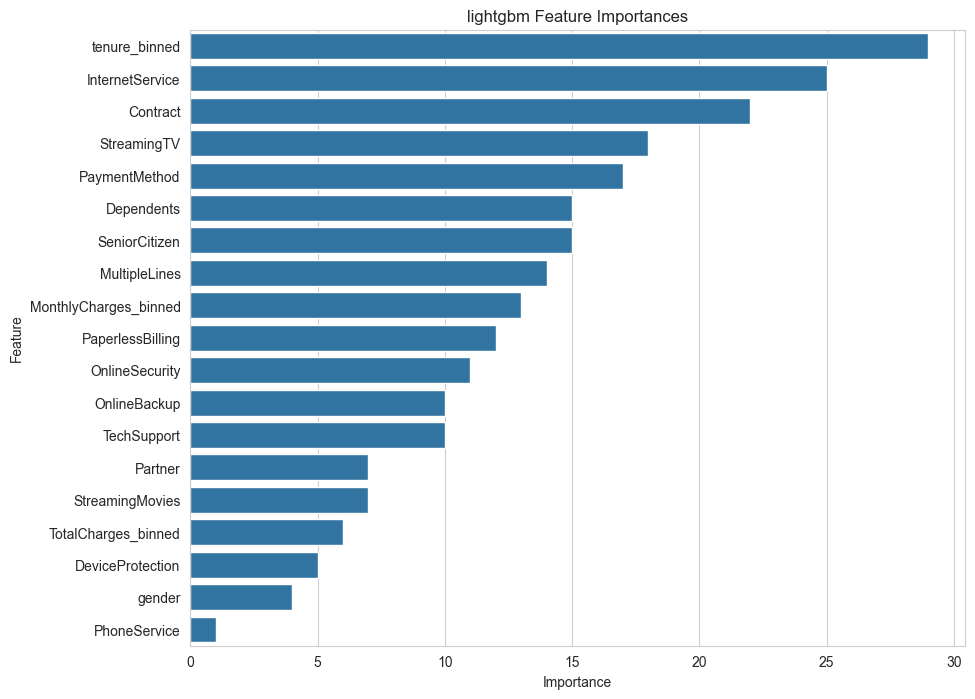

<Figure size 640x480 with 0 Axes>

In [83]:
# LightGBM model training
lightgbm = LGBMModel({
    'random_state': SEED,
    'n_estimators': 12749, 
    'learning_rate': 0.2, 
    'reg_alpha': 9.8, 
    'reg_lambda': 5.0, 
    'max_depth': 56, 
    'num_leaves': 921, 
    'min_child_samples': 85, 
    'cat_smooth': 92,
    'colsample_bytree': 0.43, 
    'min_data_per_group': 59,
    'cat_l2': 17,
    'verbosity': -1
}, SEED)
lightgbm.fit(X_pretrain, y_pretrain, X_test, y_test)
lightgbm.plot()
lightgbm.save()

#### Optuna Hyperparameter Optimization

For this step, we'll try to find the best values for each hyperparameter for each modeling technique. To accelerate this step, we'll enable GPU usage. Feel free to change the `device` flag to 'cpu' if you aren't running this in a GPU-enabled environment. 

##### Objective Functions for Optuna

In [18]:
# Set device
device = 'cpu'

# Split training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_pretrain, y_pretrain, train_size=TRAIN_TEST_RATIO, random_state=SEED, stratify=y_pretrain, shuffle=True)

In [19]:
# Define XGBoost objective for optuna hyperparameter optimization
def xgboost_objective(trial):
    model = XGBClassifier(**{
        'random_state': SEED,
        'n_estimators': 10000,  
        'max_depth': trial.suggest_int('max_depth',3,12),
        'learning_rate': trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
        'reg_lambda': trial.suggest_categorical('reg_lambda',[0.1, 1, 5, 10, 50, 100]),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.2,0.99,log=True), 
        'subsample': trial.suggest_float('subsample',0.2,0.99,log=True),
        'eval_metric': trial.suggest_categorical('eval_metric',['auc']),
        'gamma': trial.suggest_categorical('gamma',[0, 0.25, 0.5, 1.0]),
        'enable_categorical': True,
        'tree_hist': 'gpu_hist' if device == 'gpu' else 'hist',                   # Enable GPU usage
    })
    model.fit(X_train, y_train, verbose=False)
    return roc_auc_score(y_val, model.predict_proba(X_val)[:,1])

# Define CatBoost objective for optuna hyperparameter optimization
def catboost_objective(trial):
    model = CatBoostClassifier(**{
        'iterations' : trial.suggest_int('iterations', 6000, 8000), 
        'colsample_bylevel': trial.suggest_float("colsample_bylevel", 1e-2, 0.1),
        'depth' : trial.suggest_int('depth', 3, 12),
        'learning_rate' :trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        "objective": trial.suggest_categorical("objective", ["Logloss"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),   
        'random_state': SEED
    })
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    return roc_auc_score(y_val, model.predict_proba(X_val)[:,1])

# Define LightGBM objective for optuna hyperparameter optimization
def lightgbm_objective(trial):
    model = LGBMClassifier(**{
        'random_state': SEED,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 4000, 20000),
        'learning_rate' : trial.suggest_float('learning_rate',1e-3,5e-1,log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 64),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0),
        'objective': 'binary',
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 5, 1000),
        'cat_l2': trial.suggest_int('cat_l2', 1, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'cat_smooth' : trial.suggest_int('cat_smooth', 10, 100),
        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
        'device': device,                            # Enable GPU usage
        'verbosity': -1
    })
    model.fit(X_train, y_train)
    return roc_auc_score(y_val, model.predict_proba(X_val)[:,1])


##### Optimization

In [20]:
from multiprocessing import cpu_count

n_trials = 50
n_jobs = cpu_count()
tpe_sampler = optuna.samplers.TPESampler(seed=SEED)

print("Available CPUs:", n_jobs)

Available CPUs: 8


In [21]:
print("--- Optimized XGBOOST ---")

# XGBoost Optuna
xgboost_study = optuna.create_study(sampler=tpe_sampler, direction="maximize")
xgboost_study.optimize(xgboost_objective, n_trials, n_jobs=n_jobs)

# Display XGBoost results
print(f"AUC Score:\t{xgboost_study.best_value}")
display(optuna.visualization.plot_optimization_history(xgboost_study))
display(plot_param_importances(xgboost_study))

[I 2024-09-05 10:42:58,725] A new study created in memory with name: no-name-f6a87f23-a115-4f4b-ac68-6b1820cd4566


--- Optimized XGBOOST ---


[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.

[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.
[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.


[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.

[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.

[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.

[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.

[10:42:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "tree_hist" } are not used.

[I 2024-09-05 10:43:34,402] Trial 3 finished wit

AUC Score:	0.8334928828785162


In [22]:
print("--- Optimized CATBOOST ---")

# CatBoost Optuna
catboost_study = optuna.create_study(sampler=tpe_sampler, direction="maximize")
catboost_study.optimize(catboost_objective, n_trials, n_jobs=n_jobs)

# Display CatBoost results
print(f"AUC Score:\t{catboost_study.best_value}")
display(optuna.visualization.plot_optimization_history(catboost_study))
display(plot_param_importances(catboost_study))

[I 2024-09-05 10:50:40,773] A new study created in memory with name: no-name-9456c491-3bb6-487e-a2e6-bf3381afc08a


--- Optimized CATBOOST ---


[I 2024-09-05 10:50:45,772] Trial 3 finished with value: 0.8291385940251724 and parameters: {'iterations': 6438, 'colsample_bylevel': 0.04213262415341392, 'depth': 5, 'learning_rate': 0.04568221458849477, 'objective': 'Logloss', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'random_strength': 20}. Best is trial 3 with value: 0.8291385940251724.
[I 2024-09-05 10:50:46,353] Trial 2 finished with value: 0.824239009257913 and parameters: {'iterations': 6922, 'colsample_bylevel': 0.026471376098874608, 'depth': 7, 'learning_rate': 0.002539358867680636, 'objective': 'Logloss', 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'random_strength': 48}. Best is trial 3 with value: 0.8291385940251724.
[I 2024-09-05 10:50:46,491] Trial 7 finished with value: 0.8305038534244582 and parameters: {'iterations': 6960, 'colsample_bylevel': 0.03981186240234901, 'depth': 6, 'learning_rate': 0.059020911890031676, 'objective': 'Logloss', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian

AUC Score:	0.8328102531788732


In [23]:
print("--- Optimized LIGHTGBM ---")

# LightGBM Optuna
lightgbm_study = optuna.create_study(sampler=tpe_sampler, direction="maximize")
lightgbm_study.optimize(lightgbm_objective, n_trials, n_jobs=n_jobs)

# Display LightGBM results
print(f"AUC Score:\t{lightgbm_study.best_value}")
display(optuna.visualization.plot_optimization_history(lightgbm_study))
display(plot_param_importances(lightgbm_study))

[I 2024-09-05 10:52:28,614] A new study created in memory with name: no-name-d0ae760a-7fe3-49af-a027-d0d20490d49d


--- Optimized LIGHTGBM ---


[I 2024-09-05 10:52:44,049] Trial 1 finished with value: 0.8312874638489006 and parameters: {'colsample_bytree': 0.4078130550131308, 'n_estimators': 6500, 'learning_rate': 0.10836758330076715, 'max_depth': 52, 'reg_lambda': 4.594333176863098, 'reg_alpha': 5.69389645080279, 'num_leaves': 435, 'cat_l2': 5, 'min_child_samples': 95, 'cat_smooth': 44, 'min_data_per_group': 162}. Best is trial 1 with value: 0.8312874638489006.
[I 2024-09-05 10:52:45,138] Trial 2 finished with value: 0.8312066792690611 and parameters: {'colsample_bytree': 0.2535384213021637, 'n_estimators': 4461, 'learning_rate': 0.055815059384122206, 'max_depth': 39, 'reg_lambda': 9.207581584484764, 'reg_alpha': 2.3781264093175185, 'num_leaves': 188, 'cat_l2': 15, 'min_child_samples': 47, 'cat_smooth': 97, 'min_data_per_group': 61}. Best is trial 1 with value: 0.8312874638489006.
[I 2024-09-05 10:52:49,015] Trial 6 finished with value: 0.8171097700870856 and parameters: {'colsample_bytree': 0.45507747598594117, 'n_estimators

AUC Score:	0.8342260029405587


In [24]:
import json
# Save best params for each model
def save_best_params(study, model_name):
    with open(f"{model_name}_params.json", 'w') as f:
        json.dump(study.best_params, f)

save_best_params(xgboost_study, 'xgboost')
save_best_params(catboost_study, 'catboost')
save_best_params(lightgbm_study, 'lightgbm')

### Stacked Ensemble Model Training

In [25]:
# Retrieve best params for each model
def get_best_params(model_name):
    with open(f'../params/{model_name}_params.json') as f:
        return json.load(f)

xgboost_best_params = get_best_params('xgboost')
catboost_best_params = get_best_params('catboost')
lightgbm_best_params = get_best_params('lightgbm')

In [26]:
# Fit models with best params (found via Optuna)
xgboost_pretrain, xgboost_test = XGBModel(xgboost_best_params, SEED).fit(
    X_pretrain, y_pretrain, X_test, y_test
)
catboost_pretrain, catboost_test = CBModel(catboost_best_params, SEED).fit(
    X_pretrain, y_pretrain, X_test, y_test
)
lightgbm_pretrain, lightgbm_test = LGBMModel(lightgbm_best_params, SEED).fit(
    X_pretrain, y_pretrain, X_test, y_test
)

Fold 1 - Training Start
Fold 1 - Training Done | Fold AUC: 0.817
Fold 2 - Training Start
Fold 2 - Training Done | Fold AUC: 0.843
Fold 3 - Training Start
Fold 3 - Training Done | Fold AUC: 0.841
Fold 4 - Training Start
Fold 4 - Training Done | Fold AUC: 0.820
Fold 5 - Training Start
Fold 5 - Training Done | Fold AUC: 0.824
Fold 6 - Training Start
Fold 6 - Training Done | Fold AUC: 0.833
Fold 7 - Training Start
Fold 7 - Training Done | Fold AUC: 0.831
Fold 8 - Training Start
Fold 8 - Training Done | Fold AUC: 0.842
Fold 9 - Training Start
Fold 9 - Training Done | Fold AUC: 0.820
Fold 10 - Training Start
Fold 10 - Training Done | Fold AUC: 0.813
xgboost Training Set             AUC Score	mean=0.828	std=0.011
xgboost Testing Set              AUC Score=0.814
Fold 1 - Training Start
Fold 1 - Training Done | Fold AUC: 0.831
Fold 2 - Training Start
Fold 2 - Training Done | Fold AUC: 0.848
Fold 3 - Training Start
Fold 3 - Training Done | Fold AUC: 0.852
Fold 4 - Training Start
Fold 4 - Trainin

In [35]:
# Retrieve model from file
def get_model(model_name: str):
    if model_name == 'xgboost':
        model = XGBClassifier()
        model.load_model("../models/xgboost.json")
    elif model_name == 'catboost':
        model = CatBoostClassifier()
        model.load_model("../models/catboost")
    else:
        model = Booster(model_file="../models/lightgbm.txt")
    return model

# Run churn prediction on input
def predict_churn(model, x):
    try:
        return model.predict_proba(x)[:, 1]
    except AttributeError:
        return model.predict(x)

# Plot Retriever Operating Characteristic Area-Under Curve (ROC-AUC)
def plot_roc_curve(model, X, y):
    """
    Given true labels `y`, plot the ROC Curve for model predictions on test set `X`.

    Args:
        model (Object): The model used to make predictions on test set `X`.
        X (Object): The test set DataFrame whose predictions will be compared to true labels `y`
        y (List[int]): The true labels (`0` = No Churn, `1` = Churn)
    
    Returns:
        (Object, float): Tuple containing Matplotlib figure and ROC-AUC score
    """

    preds = predict_churn(model, X)
    fpr, tpr, _ = roc_curve(y, preds)
    
    xy_range = [0, 1]
    plt.plot(fpr, tpr, 'b', label=f"AUC = {auc(fpr, tpr):.2f}")
    plt.plot(xy_range, xy_range, 'r--', label="No Skill")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(xy_range)
    plt.ylim(xy_range)
    plt.title('Retriever Operating Characteristic Curve')
    plt.legend()

    return plt, roc_auc_score(y, preds)

XGBoost Model:
ROC-AUC Score = 0.829


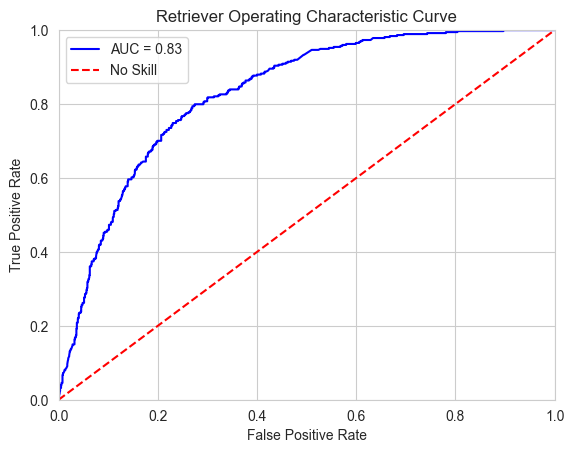

In [36]:
xgb_model = get_model("xgboost")
plt, rocauc = plot_roc_curve(xgb_model, X_test, y_test)
print(f"XGBoost Model:\nROC-AUC Score = {rocauc:.3f}")
plt.show()

CatBoost Model:
ROC-AUC Score = 0.832


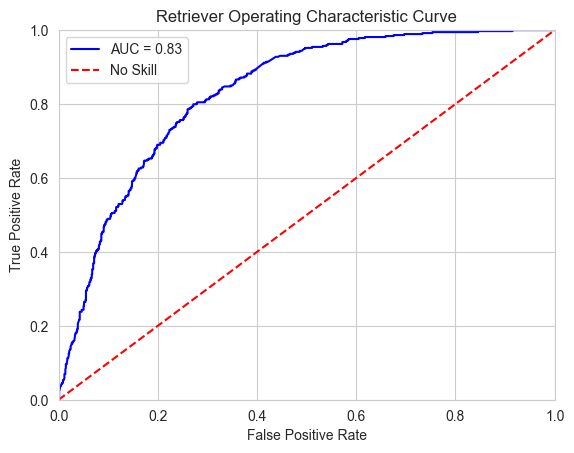

In [37]:
catb_model = get_model("catboost")
plt, rocauc = plot_roc_curve(catb_model, X_test, y_test)
print(f"CatBoost Model:\nROC-AUC Score = {rocauc:.3f}")
plt.show()

LightGBM Model:
ROC-AUC Score = 0.832


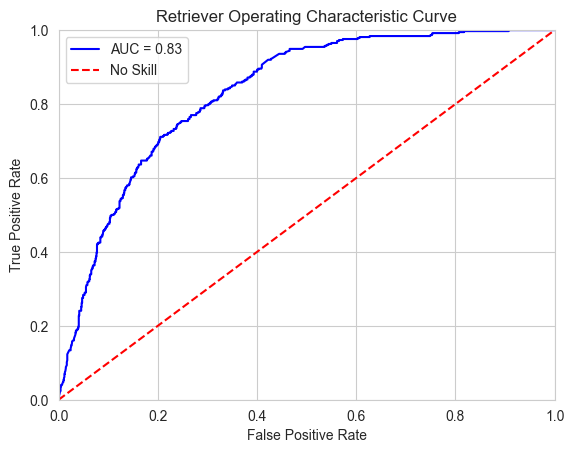

In [38]:
lgbm_model = get_model("lightgbm")
plt, rocauc = plot_roc_curve(lgbm_model, X_test, y_test)
print(f"LightGBM Model:\nROC-AUC Score = {rocauc:.3f}")
plt.show()

In [ ]:
# Stack datasets
stacked_pretrain = np.concatenate((xgboost_pretrain, catboost_pretrain, lightgbm_pretrain), axis=1)
stacked_test = np.concatenate((xgboost_test, catboost_test, lightgbm_test), axis=1)

In [ ]:
# Fit Stacked Ensemble model
n_splits=5
test_preds_lr = np.zeros((stacked_test.shape[0], n_splits))
auc_scores = []

folds = StratifiedKFold(n_splits=n_splits, random_state=SEED, shuffle=True)
for fold_index, (train_indices, val_indices) in enumerate(folds.split(stacked_pretrain, y_pretrain), start=1):
    X_train, y_train = stacked_pretrain[train_indices], y_pretrain[train_indices]
    X_val, y_val = stacked_pretrain[val_indices], y_pretrain[val_indices]
    
    lr = LogisticRegression(n_jobs=n_jobs, random_state=SEED, C=0.3, max_iter=10000)
    lr.fit(X_train, y_train)
    
    val_preds_lr = lr.predict_proba(X_val)[:, 1]
    test_preds_lr[:, fold_index] = lr.predict_proba(stacked_test)[:, 1]

    auc = roc_auc_score(y_val, val_preds_lr)
    auc_scores.append(auc)

    print(f"Fold {fold_index} - Training Done | Fold AUC: {auc:.3f}")

# Average test predictions across all folds
test_preds_lr_mean = np.mean(test_preds_lr, axis=1).reshape(-1, 1)
test_auc_score = roc_auc_score(y_test, test_preds_lr_mean)

# Print overall AUC scores
print(f"Stacked Ensemble Training Set".ljust(32), 
        f"AUC Score\tmean={np.mean(auc_scores):.3f}\tstd={np.std(auc_scores):.3f}")
print(f"Stacked Ensemble Testing Set".ljust(32), 
        f"AUC Score={test_auc_score:.3f}")

### Stacking Ensemble of Models

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('logreg', LogisticRegression()))
    level0.append(('knn', KNeighborsClassifier()))
    level0.append(('rforest', RandomForestClassifier()))
    level0.append(('etree', ExtraTreesClassifier()))
    level0.append(('svm', SVC()))

    # define meta learner model
    level1 = LogisticRegression()

    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['logreg'] = LogisticRegression()
    models['knn'] = KNeighborsClassifier()
    models['rforest'] = RandomForestClassifier()
    models['etree'] = ExtraTreesClassifier()
    models['svm'] = SVC()
    models['stacking'] = get_stacking()
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()

print("Model Evaluation:")

for name, model in models.items():
    scores = evaluate_model(model, X_pretrain, y_pretrain)
    results.append(scores)
    names.append(name)
    print(f"\t{name}, Cross-Validation Score - mean: {np.mean(scores):.3f} std: {np.std(scores):.3f})")


Model Evaluation:
	logreg, Cross-Validation Score - mean: 0.779 std: 0.015)
	knn, Cross-Validation Score - mean: 0.750 std: 0.017)
	rforest, Cross-Validation Score - mean: 0.767 std: 0.012)
	etree, Cross-Validation Score - mean: 0.759 std: 0.011)
	svm, Cross-Validation Score - mean: 0.793 std: 0.015)
	stacking, Cross-Validation Score - mean: 0.786 std: 0.011)


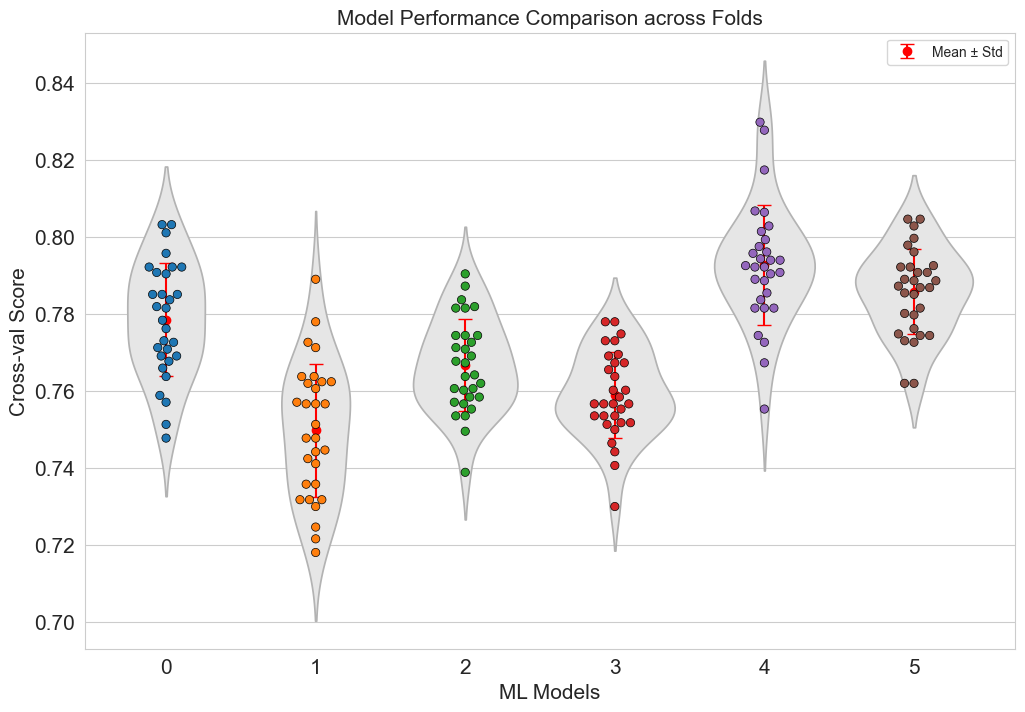

In [16]:
# Plot model performance for comparison with violin + swarm plots
plt.figure(figsize=(12,8))
font_size = 15

# Violin plot to show the distribution
sns.violinplot(data=results, inner=None, color=".9", linecolor=".7")

# Swarm plot to show the individual data points
sns.swarmplot(data=results, size=6, edgecolor="k", linewidth=0.5)

# Mean and std deviation for each model
for i in range(len(results)):
    mean = np.mean(results[i])
    std = np.std(results[i])
    plt.errorbar(i, mean, yerr=std, fmt='o', color='red', capsize=5, label="Mean ± Std" if i == 0 else "")

# Add labels and title
plt.title("Model Performance Comparison across Folds", fontsize=font_size)
plt.xlabel("ML Models", fontsize=font_size)
plt.ylabel("Cross-val Score", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

# Show the plot
plt.legend()
plt.show()